In [1]:
import pickle
import numpy as np
from skimage import io
import random
import time

from tqdm import tqdm, trange 
from PIL import Image
from pathlib import Path
from torch.optim import lr_scheduler
from torchvision import models
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import pandas as pd
import torch

import PIL
print("PIL version:", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available! Training on GPU ...")

PIL version: 9.3.0
CUDA is available! Training on GPU ...


In [2]:
DATA_MODES = ["train", "val", "test"]
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

# EDA

Для початку, давайте ознайомимося з кількістю екземплярів кожного класу у нашій тренувальній вибірці.

In [3]:
TRAIN_DIR = Path("./train/")
TEST_DIR = Path("./testset")

In [4]:
train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))

print("Кількість зображеь у тренувальній вибірці: ", len(train_val_files))
print("Кількість зображеь у тестовій вибірці: ", len(test_files))

train_val_dirs = list(set([file.parent.name for file in train_val_files]))

simpsons_statistics = dict()
for dir in train_val_dirs[1:]:
    files = sorted(list(Path(f"./train/simpsons_dataset/{dir}/").rglob("*.jpg")))
    simpsons_statistics[dir] = len(files)

simpsons_statistics = pd.DataFrame(list(simpsons_statistics.items()), columns=["Character", "Count"])
simpsons_statistics.head()

Кількість зображеь у тренувальній вибірці:  58934
Кількість зображеь у тестовій вибірці:  991


,Character,Count
0,homer_simpson,2246
1,cletus_spuckler,47
2,chief_wiggum,986
3,kent_brockman,498
4,carl_carlson,98


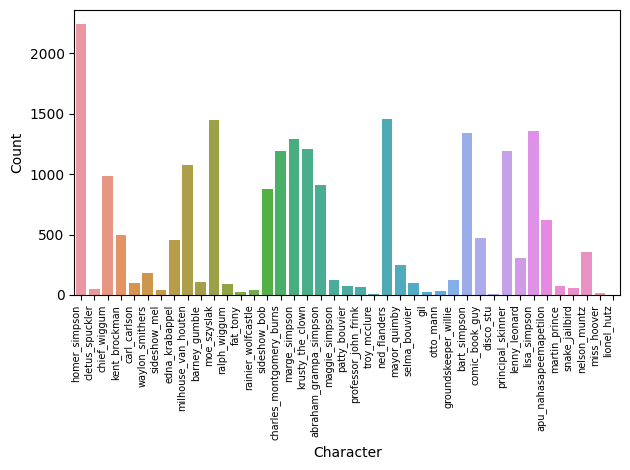

In [5]:
sns_plot = sns.barplot(data=simpsons_statistics, x="Character", y="Count")
sns_plot.set_xticklabels(
    sns_plot.get_xticklabels(), rotation=90, horizontalalignment="right", fontsize=7
)
plt.tight_layout()
plt.show()

**Висновок щодо розподілу екземлярів кожного класу**

Спираючись на графік, ми можемо бачити, що в наших тренувальних даних є експліцитний дисбаланс екземплярів класів. Саме тому нам необхідно виконати розмноження та аугментацію даних, для підвищення якості нашої моедлі.

#### Аугментація даних

In [5]:
transform_with_augm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomChoice(
            [
                transforms.RandomAutocontrast(),
                transforms.ColorJitter(0.5, 0.5),
                transforms.RandomPerspective(),
                transforms.RandomGrayscale(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
            ]
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
transform_with_no_augm = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

#### Підготовка датасету

In [6]:
class SimpsonsDataset():
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open("label_encoder.pkl", "wb") as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode != "train":
            transform = transform_with_no_augm
        else:
            # transform = transform_with_augm
            transform = transform_with_no_augm

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)

        if self.mode == "test":
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

#### Розмноження даних

In [116]:
import shutil

shutil.copytree(Path("./train/simpsons_dataset/"), "./train/simpsons_dataset_multiplied")

In [7]:
TRAIN_DIR = Path("./train/simpsons_dataset_multiplied")

In [9]:
import os

folders = [
    name
    for name in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, name))
]

train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))
print("Кількість зображеь у тренувальній вибірці: ", len(train_val_files))
print("Кількість зображеь у тестовій вибірці: ", len(test_files))

for folder in folders: 
    content = os.listdir(os.path.join(TRAIN_DIR, folder))
    while len(content) < 500:
        i = 0
        for file in content:
            base, extension = os.path.splitext(file)
            new_file = os.path.join(base + str(i) + extension)
            shutil.copy(
                os.path.join(TRAIN_DIR, folder, file),
                os.path.join(TRAIN_DIR, folder, new_file),
            )
            i += 1
        content = os.listdir(os.path.join(TRAIN_DIR, folder))

train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))

Кількість зображеь у тренувальній вибірці:  58934
Кількість зображеь у тестовій вибірці:  991


NameError: name 'shutil' is not defined

In [10]:
import os

folders = [
    name
    for name in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, name))
]

train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))
print(
    "Кількість зображеь у тренувальній вибірці після розмноження: ",
    len(train_val_files),
)
print("Кількість зображеь у тестовій вибірці: ", len(test_files))

Кількість зображеь у тренувальній вибірці після розмноження:  58934
Кількість зображеь у тестовій вибірці:  991


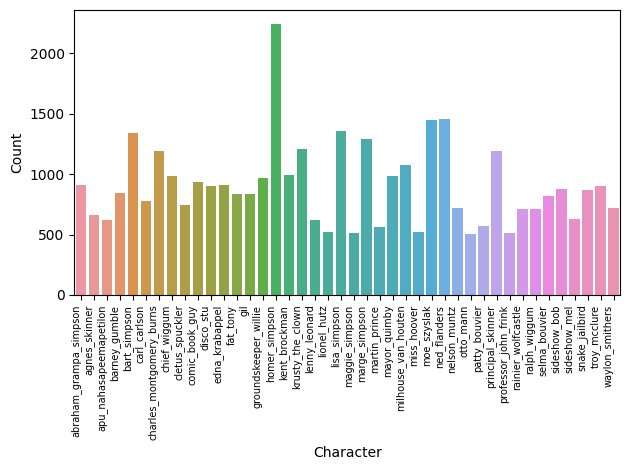

In [11]:
simpsons_multiplied_statistics = dict()
for folder in folders:
    files = sorted(list(Path(f"./train/simpsons_dataset_multiplied/{folder}/").rglob("*.jpg")))
    simpsons_multiplied_statistics[folder] = len(files)

simpsons_multiplied_statistics = pd.DataFrame(
    list(simpsons_multiplied_statistics.items()), columns=["Character", "Count"]
)
simpsons_multiplied_statistics.head()

sns_plot = sns.barplot(data=simpsons_multiplied_statistics, x="Character", y="Count")
sns_plot.set_xticklabels(
    sns_plot.get_xticklabels(), rotation=90, horizontalalignment="right", fontsize=7
)
plt.tight_layout()
plt.show()

**Висновок щодо розмноження**

В ході розмноження даних я збільшив кількість зображень для всіх класів, що налічували меньше 500 екземплярів. Таким чином ми зможемо добитися кращої якості класифікації нашої моделі.

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.3, stratify=train_val_labels
)

print("Кількість зображеь у тренувальній вибірці: ", len(train_files))
print("Кількість зображеь у валідаційній вибірці: ", len(val_files))

val_dataset = SimpsonsDataset(val_files, mode="val")
train_dataset = SimpsonsDataset(train_files, mode="train")

Кількість зображеь у тренувальній вибірці:  41253
Кількість зображеь у валідаційній вибірці:  17681


Тепер виведемо декілька зображень персонажів з тренувальної вибірки, щоб зрозуміти як аугментація відобразилася на даних.

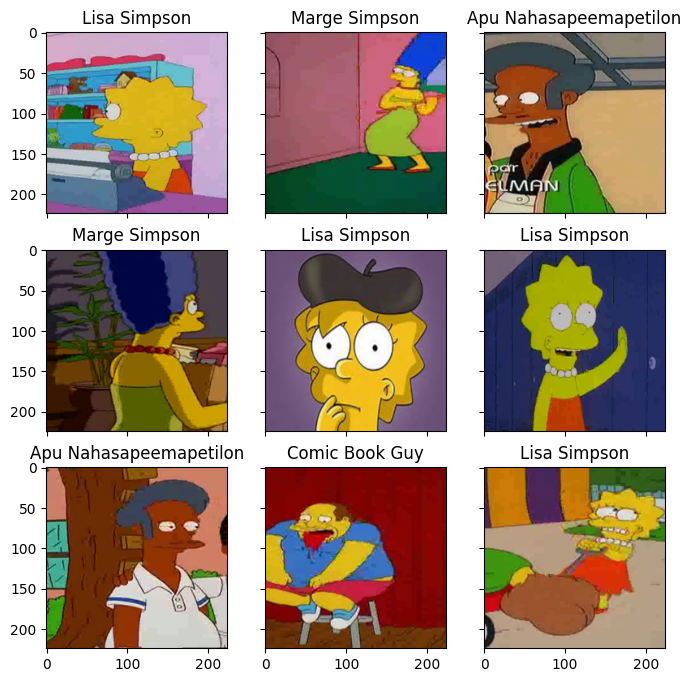

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 10000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(
        map(
            lambda x: x.capitalize(),
            train_dataset.label_encoder.inverse_transform([label])[0].split("_"),
        )
    )
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

# Modeling

Для початку, побудую довільну архітектуру, використовуючи Adam в якості оптимізатора та стандартний learning rate - 0.001.

Потім я порівняю результати роботи такої мережі з визначними архітектурами, які будуть імпртовані та донавчені на нашому датасеті.

#### Custom CNN

In [13]:
class CustomCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=164, kernel_size=3),
            nn.BatchNorm2d(164),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 164, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(nn.Linear(1024, 1024), nn.BatchNorm1d(1024), nn.ReLU())
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 164)
        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

### Training

In [14]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    preds_list = []
    labels_list = []

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_score(labels_list, preds_list, average="weighted")
    return train_loss, train_acc, train_f1


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    preds_list = []
    labels_list = []

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = f1_score(labels_list, preds_list, average="weighted")
    return val_loss, val_acc, val_f1


def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            train_loss, train_acc, train_f1 = fit_epoch(
                model, train_loader, criterion, opt
            )
            print("loss", train_loss)

            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))

            pbar_outer.update(1)
            tqdm.write(
                log_template.format(
                    ep=epoch + 1,
                    t_loss=train_loss,
                    v_loss=val_loss,
                    t_acc=train_acc,
                    v_acc=val_acc,
                    t_f1=train_f1,
                    v_f1=val_f1,
                )
            )

    return history

In [15]:
n_classes = len(np.unique(train_val_labels))
model_1 = CustomCNN(n_classes).to(DEVICE)
optimizer = torch.optim.Adam

In [16]:
history = train(
    train_dataset,
    val_dataset,
    model=model_1,
    epochs=17,
    batch_size=32,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
)

epoch:   0%|          | 0/17 [00:00<?, ?it/s]

loss 1.0168410455596055


epoch:   6%|▌         | 1/17 [12:09<3:14:26, 729.18s/it]


Epoch 001 train_loss: 1.0168     val_loss 0.4269 train_acc 0.7209 val_acc 0.8762
loss 0.35252096594511295


epoch:  12%|█▏        | 2/17 [23:05<2:51:37, 686.53s/it]


Epoch 002 train_loss: 0.3525     val_loss 0.2419 train_acc 0.8983 val_acc 0.9246
loss 0.14953481866241627


epoch:  18%|█▊        | 3/17 [32:56<2:30:01, 642.94s/it]


Epoch 003 train_loss: 0.1495     val_loss 0.2095 train_acc 0.9551 val_acc 0.9409
loss 0.10046986066893522


epoch:  24%|██▎       | 4/17 [43:08<2:16:39, 630.75s/it]


Epoch 004 train_loss: 0.1005     val_loss 0.1466 train_acc 0.9697 val_acc 0.9598
loss 0.08188741335826583


epoch:  29%|██▉       | 5/17 [50:44<1:53:32, 567.71s/it]


Epoch 005 train_loss: 0.0819     val_loss 0.1395 train_acc 0.9761 val_acc 0.9640
loss 0.061335112906735975


epoch:  35%|███▌      | 6/17 [59:18<1:40:41, 549.26s/it]


Epoch 006 train_loss: 0.0613     val_loss 0.1971 train_acc 0.9822 val_acc 0.9524
loss 0.05151303068673688


epoch:  41%|████      | 7/17 [1:08:10<1:30:37, 543.71s/it]


Epoch 007 train_loss: 0.0515     val_loss 0.1710 train_acc 0.9858 val_acc 0.9615
loss 0.057834449229935365


epoch:  47%|████▋     | 8/17 [1:17:09<1:21:18, 542.10s/it]


Epoch 008 train_loss: 0.0578     val_loss 0.1181 train_acc 0.9841 val_acc 0.9746
loss 0.0513632426720306


epoch:  53%|█████▎    | 9/17 [1:25:34<1:10:45, 530.64s/it]


Epoch 009 train_loss: 0.0514     val_loss 0.1418 train_acc 0.9869 val_acc 0.9689
loss 0.03956584635975063


epoch:  59%|█████▉    | 10/17 [1:33:36<1:00:08, 515.51s/it]


Epoch 010 train_loss: 0.0396     val_loss 0.1159 train_acc 0.9894 val_acc 0.9750
loss 0.03971171556083912


epoch:  65%|██████▍   | 11/17 [1:42:16<51:41, 516.93s/it]  


Epoch 011 train_loss: 0.0397     val_loss 0.1409 train_acc 0.9896 val_acc 0.9709
loss 0.03986121192074645


epoch:  71%|███████   | 12/17 [1:52:15<45:08, 541.78s/it]


Epoch 012 train_loss: 0.0399     val_loss 0.1483 train_acc 0.9897 val_acc 0.9708
loss 0.03345419207037614


epoch:  76%|███████▋  | 13/17 [2:02:35<37:41, 565.49s/it]


Epoch 013 train_loss: 0.0335     val_loss 0.1350 train_acc 0.9919 val_acc 0.9748
loss 0.03792306963616263


epoch:  82%|████████▏ | 14/17 [2:10:48<27:11, 543.81s/it]


Epoch 014 train_loss: 0.0379     val_loss 0.1310 train_acc 0.9898 val_acc 0.9780
loss 0.038470303772546295


epoch:  88%|████████▊ | 15/17 [2:19:00<17:36, 528.11s/it]


Epoch 015 train_loss: 0.0385     val_loss 0.1880 train_acc 0.9910 val_acc 0.9673
loss 0.022458920927483337


epoch:  94%|█████████▍| 16/17 [2:28:43<09:04, 544.45s/it]


Epoch 016 train_loss: 0.0225     val_loss 0.3310 train_acc 0.9939 val_acc 0.9476
loss 0.043569089739934494


epoch: 100%|██████████| 17/17 [2:45:18<00:00, 583.45s/it]


Epoch 017 train_loss: 0.0436     val_loss 0.1385 train_acc 0.9901 val_acc 0.9778


In [17]:
loss, acccuracy, f1, val_loss, val_acccuracy, val_f1 = zip(*history)
val_acccuracy = [val.cpu().item() for val in val_acccuracy]

In [19]:
print("Best training loss:", round(loss[-1], 3))
print("Best validation loss:", round(val_loss[-1], 3))

print("Best training f1 score:", round(f1[-1], 3))
print("Best validation f1 score:", round(val_f1[-1], 3))

Best training loss: 0.044
Best validation loss: 0.138
Best training f1 score: 0.99
Best validation f1 score: 0.978


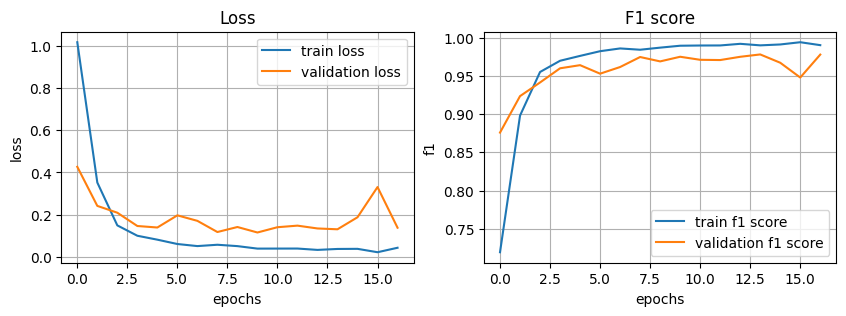

In [20]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].set_title("Loss")
ax[0].plot(np.arange(0, 17), loss, label="train loss")
ax[0].plot(np.arange(0, 17), val_loss, label="validation loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[0].grid()

ax[1].set_title("F1 score")
ax[1].plot(np.arange(0, 17), f1, label="train f1 score")
ax[1].plot(np.arange(0, 17), val_f1, label="validation f1 score")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("f1")
ax[1].legend()
ax[1].grid()

**Висновок, щодо навчання CustomCNN**
1. 17 епох навчання показали непоганий результат: f1 score **0.99** на тренувальній та **0.978** на валідаційній вибірках;
2. Точність моделі продовжує рости на 17 ітерації, що свідчить про те, що можна продовжувати навчання. Проте маючи часові обмеження ми зупинимося на сімнадсяти епохах;
4. Оптимізатор ADAM є оптимальним для подібного роду архітектур;
5. При збільшенні кількості ітерацій є сенс додати learnin rate scheduler. Я використаю його для тренування моделі ResNet18.

З всього вищесказаного роблю висновок, що результат роботи моделі на валідаційній вибірці є непоганим. Кількість ітерацій вибрана оптимальною, так як на останній епосі вже помітні ознаки перенавчання.

Тепер варто порівняти таку архітектуру з донавченою ResNet18.

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for batch in test_loader:
            batch = batch.to(DEVICE)
            model.eval()
            outputs = model(batch).cpu()
            logits.append(outputs)

    preds = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return preds

In [22]:
label_encoder = pickle.load(open("label_encoder.pkl", "rb"))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
preds = predict(model_1, test_loader)

preds = label_encoder.inverse_transform(np.argmax(preds, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [23]:
submit = pd.DataFrame({"Id": test_filenames, "Expected": preds})
submit.to_csv("submission_CustomCNN.csv", index=False)
submit.head(4)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
